### Classification of flower images

In [1]:
import torch
from torchvision import datasets, models, transforms

In [2]:
#Setting up constants - from PyTorch documentation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

Refer to: https://pytorch.org/vision/0.8/models.html

Images which are fed into pre-trained models need to be normalised using these parameters.

In [3]:
#Chaining of transformations on images
train_transform = transforms.Compose([
    transforms.Resize(256), #Size should be atleast 224x224 for pre-trained models
    transforms.RandomResizedCrop(224), #Randomise the input images
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std) #Normalising the image 
])

#Test transformations are different
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

Dataset: https://www.kaggle.com/datasets/imsparsh/flowers-dataset

In [4]:
import zipfile
zip = zipfile.ZipFile('datasets/flowers_.zip')
zip.extractall('datasets/flowers_')

In [5]:
data_dir = 'datasets/flowers_'

In [6]:
image_datasets = {}

In [7]:
image_datasets['train'] = datasets.ImageFolder(data_dir + '/train', train_transform)

In [8]:
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd

In [9]:
folder = data_dir + '/test'
if not os.path.exists(folder):
    os.makedirs(folder)
    
test_files = pd.DataFrame(enumerate(sorted(os.listdir(folder))))
test_files.head()

,0,1
0,0,Image_1.jpg
1,1,Image_10.jpg
2,2,Image_100.jpg
3,3,Image_101.jpg
4,4,Image_102.jpg


In [10]:
class TestDataset(Dataset):
    def __init__(self, test_files, path, transform=None):
        self.file_names = test_files
        #print(self.file_names)
        self.path = path
        self.transform = transform
    
    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        #if torch.isTensor(index):
            #index = index.tolist()
            
        img_name =  os.path.join(self.path, self.file_names.iloc[index, 1])
        img = Image.open(img_name)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, self.file_names.iloc[index, 1]

In [11]:
image_datasets['test'] = TestDataset(test_files, data_dir + '/test', test_transform)

In [12]:
print(len(image_datasets['train']))
print(len(image_datasets['test']))

2746
924


In [13]:
class_names = image_datasets['train'].classes
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [14]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 2746
     Root location: datasets/flowers_/train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': <__main__.TestDataset at 0x203ea8a66d0>}

In [15]:
dataloaders = {}

In [16]:
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'],
                                                  batch_size=8,
                                                  shuffle=True,
                                                  num_workers=0)

In [17]:
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'],
                                                  batch_size=1,
                                                  shuffle=False,
                                                  num_workers=0)

In [18]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x203ea8a6940>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x203ea8a6c10>}

In [19]:
inputs, labels = next(iter(dataloaders['train']))

In [20]:
i, l = next(iter(dataloaders['test']))

In [21]:
i.shape

torch.Size([1, 3, 224, 224])

In [22]:
inputs.shape #[batch_size, num_channels, height, width]

torch.Size([8, 3, 224, 224])

In [23]:
labels #presents the 5 categories of flowers

tensor([0, 2, 0, 1, 1, 1, 0, 1])

In [24]:
import torchvision

In [25]:
inp = torchvision.utils.make_grid(inputs) #Stacking images side by side with padding

In [26]:
inp.shape

torch.Size([3, 228, 1810])

In [27]:
inp.max() # max R/G?B value is 2.64

tensor(2.6400)

In [28]:
import numpy as np

np.clip(inp, 0, 1).max() #Matplotlib requires RGB values in range 0-1

tensor(1.)

In [29]:
inp.numpy().transpose((1, 2, 0)).shape #converting to format required by matplotlib; channels should be the las dimension

(228, 1810, 3)

In [30]:
import matplotlib.pyplot as plt

plt.ion()

In [31]:
def img_show(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(16,4))
    plt.axis('off')
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)

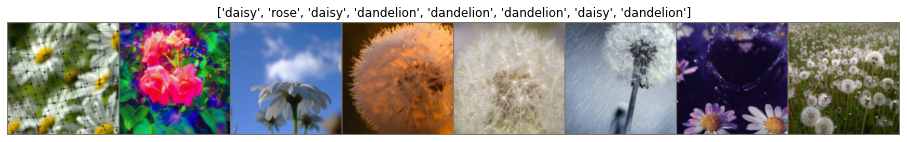

In [32]:
img_show(inp, title=[class_names[x] for x in labels])

In [33]:
model = models.resnet18(weights = models.ResNet18_Weights.DEFAULT) #IMAGENET1K_V1

We will use the pre-trained model as is except we will add a last linear layer which works with our data. This will replace the linear layer that is currently present in the pre-trained model

In [34]:
num_ftrs = model.fc.in_features #number of input feaures in last linear layer
num_ftrs

512

In [35]:
import torch.nn as nn

In [36]:
model.fc = nn.Linear(num_ftrs, 5) #input size is 512; output size is number of classes

In [37]:
#Classification problem
criterion = nn.CrossEntropyLoss()

In [38]:
import torch.optim as optim

#Stochastic Gradient descent optimiser - momentum to accelerate model convergence
optimiser = optim.SGD(model.parameters(),
                     lr=0.001,
                     momentum=0.9)

In [39]:
#Learning rate scheduler to decay the learning rate as we get close to convergence
from torch.optim import lr_scheduler

exp_lr_scheduler = lr_scheduler.StepLR(optimiser,
                                      step_size=7,
                                      gamma=0.1)
#Reduce lr by 0.1 every 7 epochs

In [40]:
def calculate_accuracy(phase, running_loss, running_corrects):
    
    epoch_loss = running_loss / len(image_datasets[phase])
    epoch_acc = running_corrects.double() / len(image_datasets[phase])
    
    print('{} Loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return(epoch_loss, epoch_acc)

In [41]:
def train_phase(model, criterion, optimiser, scheduler):
    
    #scheduler.step() #Update learning rate of the particular epoch
    
    model.train() #Runs model in training phase
    
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloaders['train']:
        
        optimiser.zero_grad() #zero out gradients on optimiser
        
        with torch.set_grad_enabled(True): #gradients are enabled in training phase
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimiser.step() #update model parameters
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    scheduler.step() #Update learning rate of the particular epoch
    
    calculate_accuracy('train', running_loss, running_corrects)

In [ ]:
#import copy

When we are training the model, we will evaluate the accuracy of the model on the test data, and only save those model parameters that give the best accuracy

In [ ]:
#best_acc = 0.0

In [ ]:
# def test_phase(model, criterion, optimiser):
    
#     model.eval() #Runs model in test phase
    
#     running_loss = 0.0
#     running_corrects = 0
    
#     #global best_acc #keeps track of parametrs which produce best accuracy
#     predictions = []
        
#     for inputs, image_names in dataloaders['test']:
        
#         #optimiser.zero_grad() #zero out gradients on optimiser
        
#         with torch.no_grad(): #gradients are disabled
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
            
#             #loss = criterion(outputs, preds)
                        
#         #running_loss += loss.item() * inputs.size(0)
#         #running_corrects += torch.sum(preds == labels.data)
        
#         for j in range(len(inputs)):
#             predictions.append(class_names[preds[j]])

In [44]:
def build_model(model, criterion, optimiser, scheduler, num_epochs=10):
    
    #best_model_params = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        train_phase(model, criterion, optimiser, scheduler)
        #best_model_params = test_phase(model, criterion, optimiser)
        print()
        
    #print('Best test Acc: {:.4f}'.format(best_acc))
    
    #model.load_state_dict(best_model_params)
    return model

In [45]:
trained_model = build_model(model,
                   criterion,
                   optimiser,
                   exp_lr_scheduler,
                   num_epochs=25)

Epoch 0/24
----------


C:\Users\AB15\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.6900 acc: 0.7360

Epoch 1/24
----------
train Loss: 0.4850 acc: 0.8252

Epoch 2/24
----------
train Loss: 0.4190 acc: 0.8518

Epoch 3/24
----------
train Loss: 0.4154 acc: 0.8521

Epoch 4/24
----------
train Loss: 0.3381 acc: 0.8791

Epoch 5/24
----------
train Loss: 0.3272 acc: 0.8860

Epoch 6/24
----------
train Loss: 0.2816 acc: 0.9017

Epoch 7/24
----------
train Loss: 0.2538 acc: 0.9184

Epoch 8/24
----------
train Loss: 0.2462 acc: 0.9166

Epoch 9/24
----------
train Loss: 0.1994 acc: 0.9370

Epoch 10/24
----------
train Loss: 0.2297 acc: 0.9239

Epoch 11/24
----------
train Loss: 0.2020 acc: 0.9286

Epoch 12/24
----------
train Loss: 0.2190 acc: 0.9261

Epoch 13/24
----------
train Loss: 0.2115 acc: 0.9315

Epoch 14/24
----------
train Loss: 0.2183 acc: 0.9279

Epoch 15/24
----------
train Loss: 0.2104 acc: 0.9279

Epoch 16/24
----------
train Loss: 0.1883 acc: 0.9366

Epoch 17/24
----------
train Loss: 0.2053 acc: 0.9348

Epoch 18/24
----------
train Loss: 0.2008 

In [47]:
model.eval() #Runs model in test phase

predictions = {}
        
for inputs, image_names in dataloaders['test']:
        
    #optimiser.zero_grad() #zero out gradients on optimiser
        
    with torch.no_grad(): #gradients are disabled
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
            
            #loss = criterion(outputs, preds)
                        
        #running_loss += loss.item() * inputs.size(0)
        #running_corrects += torch.sum(preds == labels.data)
        
    for j in range(len(inputs)):
        predictions[image_names[0]] = class_names[preds[j]]

In [48]:
predictions

{'Image_1.jpg': 'sunflower',
 'Image_10.jpg': 'dandelion',
 'Image_100.jpg': 'daisy',
 'Image_101.jpg': 'sunflower',
 'Image_102.jpg': 'daisy',
 'Image_103.jpg': 'daisy',
 'Image_104.jpg': 'rose',
 'Image_105.jpg': 'sunflower',
 'Image_106.jpg': 'dandelion',
 'Image_107.jpg': 'sunflower',
 'Image_108.jpg': 'daisy',
 'Image_109.jpg': 'sunflower',
 'Image_11.jpg': 'sunflower',
 'Image_110.jpg': 'tulip',
 'Image_111.jpg': 'dandelion',
 'Image_112.jpg': 'sunflower',
 'Image_113.jpg': 'daisy',
 'Image_114.jpg': 'dandelion',
 'Image_115.jpg': 'dandelion',
 'Image_116.jpg': 'sunflower',
 'Image_117.jpg': 'rose',
 'Image_118.jpg': 'rose',
 'Image_119.jpg': 'tulip',
 'Image_12.jpg': 'daisy',
 'Image_120.jpg': 'dandelion',
 'Image_121.jpg': 'dandelion',
 'Image_122.jpg': 'tulip',
 'Image_123.jpg': 'rose',
 'Image_124.jpg': 'rose',
 'Image_125.jpg': 'dandelion',
 'Image_126.jpg': 'sunflower',
 'Image_127.jpg': 'rose',
 'Image_128.jpg': 'rose',
 'Image_129.jpg': 'daisy',
 'Image_13.jpg': 'dandelio

In [49]:
test_df = pd.read_csv('datasets/flowers_/Testing_set_flower.csv')
test_df.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [50]:
pred_df = pd.DataFrame(predictions.items())
pred_df.columns = ['filename', 'prediction']
pred_df.head()

,filename,prediction
0,Image_1.jpg,sunflower
1,Image_10.jpg,dandelion
2,Image_100.jpg,daisy
3,Image_101.jpg,sunflower
4,Image_102.jpg,daisy


In [51]:
final_submission = test_df.merge(pred_df, on='filename')
final_submission.head()

,filename,prediction
0,Image_1.jpg,sunflower
1,Image_2.jpg,sunflower
2,Image_3.jpg,dandelion
3,Image_4.jpg,rose
4,Image_5.jpg,rose


In [52]:
final_submission.drop(columns=['filename'], axis=1, inplace=True)
final_submission.head()

,prediction
0,sunflower
1,sunflower
2,dandelion
3,rose
4,rose


In [53]:
final_submission = final_submission.set_index('prediction')
final_submission.head()

""
prediction
sunflower
sunflower
dandelion
rose
rose


In [54]:
final_submission.to_csv('submission.csv')